In [1]:
from flask import Flask, escape, request, jsonify, Response, json
import data_fetch
import portfolio
import port_analysis
import importlib
importlib.reload(data_fetch)
importlib.reload(port_analysis)
importlib.reload(portfolio)

from portfolio import inner_port
from portfolio import index
from portfolio import mutual_fund

import pandas as pd
import numpy as np


import datetime as datetime
from dateutil.relativedelta import relativedelta
import pymysql as mdb
import compliance
from compliance import regulation
from compliance import regulation_term
from compliance import clause
import urllib
import sys
import cx_Oracle as orl
import re
import cx_Oracle as orl
import gc
from flask_caching import Cache

import time
import logging
import os
LOG_FORMAT = "%(asctime)s - %(levelname)s -%(module)s -%(funcName)s -%(lineno)d - %(message)s"
DATE_FORMAT = "%m/%d/%Y %H:%M:%S %p"

logging.basicConfig(filename=os.getcwd()+'\\app.log', level=logging.INFO, format=LOG_FORMAT, datefmt=DATE_FORMAT)

from multiprocessing import Manager
from multiprocessing import Process
from multiprocessing.pool import Pool


app = Flask(__name__)

app.config['JSON_AS_ASCII'] = False

app.config['CACHE_TYPE'] = 'simple'  # 使用本地python字典进行存储, 一级缓存
app.config['CACHE_DEFAULT_TIMEOUT'] = 24 *60 * 60  # 默认过期时间 5分钟

# 创建缓存对象

cache = Cache(app)
pa=port_analysis.port_analysis()

In [2]:
def get_mf(sdt='',ed=''):
    req_galaxy=['普通偏股型基金（A类）','偏股型基金（股票上下限60%-95%）（A类）','灵活配置型基金（股票上下限0-95%+基准股票比例60%-100%）（A类）','灵活配置型基金（股票上下限0-95%+基准股票比例30%-60%）（A类）','灵活配置型基金（股票上下限30%-80%）（A类）','标准股票型基金（A类）','绝对收益目标基金（A类）','定期开放式绝对收益目标基金（A类）','定期开放式灵活配置型基金（A类）','定期开放式偏股型基金','封闭式灵活配置型基金（A类）','封闭式科创主题偏股型基金（A类）','定期开放式股票型基金','封闭式科创主题灵活配置型基金（A类）','封闭式绝对收益目标基金','封闭式偏股型基金']

    gport=df.mutual_fund_class(ed='2020-06-30')
    gport=gport[gport['class'].isin(req_galaxy)]
    mf=mutual_fund(list(gport.code))
    mf.raw_code=list(gport.code)
    #银河分类基础上获取自定义分类list
    #去掉在期间初成立不满3个月的组合
    set_date=(pd.to_datetime(sdt) - relativedelta(months=+3)).strftime('%Y-%m-%d')
    tmp=mf.sopdate
    tmp['sopdate']=tmp.sopdate.astype(str)
    tmp=tmp[tmp['sopdate']<=set_date]
    mf.code=list(tmp.code)

    #去掉波动率低于同期中证800 50%的组合
    idx=index(['000906.SH'])
    vol_base=pa.mi_rt(port=idx,sdlst=[sdt],edlst=[ed],indicator=['vol']).value.values[0]

    tmp=pa.mi_rt(port=mf,bench=index(['000906.SH']),bmf=index(['tr_1y']),sdlst=[sdt],edlst=[ed],indicator=['vol'])
    tmp=tmp[tmp['value']>vol_base*0.6]
    mf.code=list(tmp.code)

    #得到内部组合分类:1、偏股类；2、行业类(暂不涉及)
    #内部偏股组合
    tmp=mf.mf_class(ed='2020-06-30',sys='galaxy')
    mf_stk=mutual_fund([])
    mf_stk.code=list(tmp.code.unique())
    return(mf_stk)


In [3]:
Qe=list(pd.date_range(start='2015-01-01', end='2020-06-30',freq='BQ').astype(str))
Qs=list(pd.date_range(start='2015-01-01', end='2020-06-30',freq='QS').astype(str))
Qys=[(pd.to_datetime(x) - relativedelta(months=+12)).strftime('%Y-%m-%d') for x in Qs]
Q3ys=[(pd.to_datetime(x) - relativedelta(months=+36)).strftime('%Y-%m-%d') for x in Qs]
period=[ str(pd.to_datetime(x).year*10+pd.to_datetime(x).quarter)+ 'q' for x in Qs]
date_lst=pd.DataFrame({'period':period,'qe':Qe,'qs':Qs,'qys':Qys,'q3ys':Q3ys})

In [7]:
ii=date_lst.index[1]

In [5]:
#获取每个季度的份额变动，以及过去一年的业绩数据
data_source=pd.DataFrame()
for ii in date_lst.index:
    print(ii)
    mf=get_mf(sdt=date_lst.loc[ii].q3ys,ed=date_lst.loc[ii].qe)
    #获得过去一年业绩表现数据
    mf_rt=pa.mi_rt(port=mf,bench=index(['000906.SH']),bmf=index(['tr_1y']),sdlst=[date_lst.loc[ii].qys,date_lst.loc[ii].q3ys],edlst=[date_lst.loc[ii].qs,date_lst.loc[ii].qs],indicator=['rt'])
    mf_rt.loc[(mf_rt['sdt']==date_lst.loc[ii].qys)&(mf_rt['ed']==date_lst.loc[ii].qs),'variable']='rt_1y'
    mf_rt.loc[(mf_rt['sdt']==date_lst.loc[ii].q3ys)&(mf_rt['ed']==date_lst.loc[ii].qs),'variable']='rt_3y'
    mf_rt=pd.pivot_table(mf_rt, index=['code'],columns=['variable'], values=['value'],aggfunc=np.sum).reset_index()
    col_1,col_2=zip(*mf_rt.columns.values)
    dty=max(np.array(col_1).dtype,np.array(col_2).dtype)
    col_1=np.array(col_1,dtype=dty)
    col_2=np.array(col_2,dtype=dty)
    col_1[col_2!='']=col_2[col_2!='']
    mf_rt.columns=list(col_1)
    
    
    #获得当季的份额变化
    conwd_orcl = orl.connect('lianghua','lianghua','172.16.61.36:1801/winddb')
    #份额变动
    mf_share_ed=pd.read_sql_query('select a.F_INFO_WINDCODE, a.FUNDSHARE_TOTAL from NEWWIND.ChinaMutualFundShare a where a.CHANGE_DATE='+'\''+pd.to_datetime(date_lst.loc[ii].qe).strftime('%Y%m%d')+'\'',con = conwd_orcl)
    mf_share_ed.rename(columns={'F_INFO_WINDCODE':'code','FUNDSHARE_TOTAL':'share_ed'},inplace=True)
    mf_share_sd=pd.read_sql_query('select a.F_INFO_WINDCODE, a.FUNDSHARE_TOTAL from NEWWIND.ChinaMutualFundShare a where a.CHANGE_DATE='+'\''+(pd.to_datetime(date_lst.loc[ii].qs)+ relativedelta(days=-1)).strftime('%Y%m%d')+'\'',con = conwd_orcl)
    mf_share_sd.rename(columns={'F_INFO_WINDCODE':'code','FUNDSHARE_TOTAL':'share_sd'},inplace=True)
    conwd_orcl.close()
    mf_share_diff=pd.merge(mf_share_sd,mf_share_ed,on='code',how='left')
    mf_share_diff['share_chg']=mf_share_diff['share_ed']-mf_share_diff['share_sd']
    #期初单位净值
    sunv=mf.nav(sdt=(pd.to_datetime(date_lst.loc[ii].qs)+ relativedelta(days=-1)).strftime('%Y-%m-%d'),ed=(pd.to_datetime(date_lst.loc[ii].qs)+ relativedelta(days=-1)).strftime('%Y-%m-%d'))
    #期初申赎估算
    mf_subred=pd.merge(mf_share_diff,sunv[['code','unv']],left_on=['code'][0:6],right_on=['code'][0:6],how='left')
    mf_subred['subred']=mf_subred['share_chg']*mf_subred['unv']
    tmp_data=pd.merge(mf_rt,mf_subred,left_on=['code'][0:6],right_on=['code'][0:6],how='left')
    tmp_data['period']=date_lst.loc[ii].period
    data_source=pd.concat([data_source,tmp_data],axis=0,sort=False)
    
    
    
                

0


F:\git\Basic_Classes\data_fetch.py:462: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  fnav=pd.concat([fnav,tmp_nav])


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


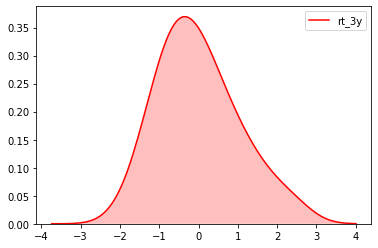

In [59]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
import seaborn as sns 
p1 = sns.kdeplot(pa.standardize(pa.MAD(data_source[['rt_3y']]))['rt_3y'], shade=True, bw=.5, color="red")

In [12]:
period=data_source.period
period=[x.replace('1q','-03-31') for x in period]
period=[x.replace('2q','-06-30') for x in period]
period=[x.replace('3q','-09-30') for x in period]
period=[x.replace('4q','-12-31') for x in period]

In [55]:
pa.MAD(pa.standardize(data_source[['share_chg']]))['share_chg']

0      -0.325640
1       0.039480
2      -0.325640
3      -0.325640
4      -0.325640
          ...   
1189    0.061852
1190    0.066364
1191    0.059064
1192    0.005661
1193    0.029196
Name: share_chg, Length: 14680, dtype: float64

In [52]:
import linearmodels
from linearmodels.panel import PanelOLS
import statsmodels.api as sm

data = data_source[['code','qm','rt_1y','rt_3y','share_chg']]

data['qm']=pd.to_datetime(data['qm'])
data=data.dropna()
data['share_chg']=pa.standardize(pa.MAD(data[['share_chg']]))['share_chg'].values
data['rt_1y']=pa.standardize(pa.MAD(data[['rt_1y']]))['rt_1y'].values
data['rt_3y']=pa.standardize(pa.MAD(data[['rt_3y']]))['rt_3y'].values
data.sort_values(by=['qm','code'],ascending=True,inplace=True)

# np.dot((vec3-np.dot(vec1,vec3)/np.dot(vec1,vec1)*vec1),vec1)
data['rt_3y_otho']=data['rt_3y']
for ii in data['qm'].unique():
    vec1=data.loc[data.qm==ii,'rt_1y'].values
    vec3=data.loc[data.qm==ii,'rt_3y'].values
    data.loc[data.qm==ii,'rt_3y_otho']=(vec3-np.dot(vec1,vec3)/np.dot(vec1,vec1)*vec1)

data = data.set_index(["code","qm"])
exog = sm.add_constant(data[['rt_1y','rt_3y']])
grunfeld_fe = PanelOLS(data['share_chg'], exog, entity_effects=False, time_effects=True)
grunfeld_fe = grunfeld_fe.fit()

D:\software\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [53]:
grunfeld_fe

Dep. Variable:,share_chg,R-squared:,0.0393
Estimator:,PanelOLS,R-squared (Between):,0.0521
No. Observations:,9326,R-squared (Within):,-0.2464
Date:,"Tue, Sep 15 2020",R-squared (Overall):,-0.1815
Time:,13:18:19,Log-likelihood,-1.261e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,190.41
Entities:,1207,P-value,0.0000
Avg Obs:,7.7266,Distribution:,"F(2,9310)"
Min Obs:,1.0000,,
Max Obs:,14.000,F-statistic (robust):,190.41


In [46]:
data.reset_index()

,code,qm,rt_1y,rt_3y,share_chg,rt_3y_otho
0,000001.OF,2015-03-31,-0.113154,0.002004,-1.578839,0.084460
1,000011.OF,2015-03-31,-0.427782,-0.325311,0.134565,-0.013585
2,000021.OF,2015-03-31,-0.250486,-0.370984,-1.578839,-0.188454
3,000031.OF,2015-03-31,-0.067815,0.199796,-1.578839,0.249213
4,000061.OF,2015-03-31,0.181842,-0.178316,-1.578839,-0.310825
...,...,...,...,...,...,...
9321,730002.OF,2020-06-30,-0.823126,-0.945136,0.263426,-0.065640
9322,740001.OF,2020-06-30,-1.374746,-1.776687,0.289412,-0.307794
9323,750001.OF,2020-06-30,0.070267,-0.188754,0.247366,-0.263833
9324,762001.OF,2020-06-30,-0.038356,-0.834188,-0.060231,-0.793205


In [93]:
period=[x.replace('1q','-03-31') for x in period]
period=[x.replace('2q','-06-30') for x in period]
period=[x.replace('3q','-09-30') for x in period]
period=[x.replace('4q','-12-31') for x in period]

In [45]:
tmp=pd.pivot_table(mf_rt, index=['code','sdt','ed'],columns=['variable'], values=['value'],aggfunc=np.sum).reset_index()
col_1,col_2=zip(*tmp.columns.values)
dty=max(np.array(col_1).dtype,np.array(col_2).dtype)
col_1=np.array(col_1,dtype=dty)
col_2=np.array(col_2,dtype=dty)
col_1[col_2!='']=col_2[col_2!='']
tmp.columns=list(col_1)

In [25]:
vec1=data['rt_1y'].values
vec3=data['rt_3y'].values

In [31]:
np.dot((vec3-np.dot(vec1,vec3)/np.dot(vec1,vec1)*vec1),vec1)

-1.4210854715202004e-12

In [37]:
pd.merge(mf_share_sd,mf_share_ed,left_on=['code'][0:6],right_on=['code'][0:6],how='left')

,code,share_sd,share_ed
0,515950.SH,20120.060000,8520.062800
1,008277.OF,221039.814643,94782.411234
2,008994.OF,NaN,NaN
3,008238.OF,55612.904230,17288.077747
4,008239.OF,NaN,NaN
...,...,...,...
568,515980.SH,57506.450000,44906.450000
569,515990.SH,327635.020000,195935.016000
570,518800.SH,15701.990000,14891.986500
571,518880.SH,247984.080000,278464.084700


In [41]:
mf.nav(sdt=date_lst.loc[ii].qe,ed=date_lst.loc[ii].qs)

F:\git\Basic_Classes\data_fetch.py:462: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  fnav=pd.concat([fnav,tmp_nav])


,code,date,nav,rt,tnav,unv,unv_cum
0,000001.OF,2010-01-01,0.0,0.0,0.0,0.0,0.0
1,000011.OF,2010-01-01,0.0,0.0,0.0,0.0,0.0
2,000021.OF,2010-01-01,0.0,0.0,0.0,0.0,0.0
3,000031.OF,2010-01-01,0.0,0.0,0.0,0.0,0.0
4,002011.OF,2010-01-01,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
225,610002.OF,2010-01-01,0.0,0.0,0.0,0.0,0.0
226,620002.OF,2010-01-01,0.0,0.0,0.0,0.0,0.0
227,630001.OF,2010-01-01,0.0,0.0,0.0,0.0,0.0
228,630002.OF,2010-01-01,0.0,0.0,0.0,0.0,0.0
